## import packages

In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mping
from sklearn.metrics import confusion_matrix
from tensorflow.python import pywrap_tensorflow
import os
import data_process
import model
import math
%matplotlib inline

## Configuration and Hyperparameters

In [2]:
N_CLASSES = 2
IMG_W = 256 
IMG_H = 256
IMG_C = 3
RATIO = 0.2  # take 20% of dataset as validation data
BATCH_SIZE = 32

train_dir = '/search/odin/xudongmei/working/datasets/bak2_crop/train_split/'
test_dir = '/search/odin/xudongmei/working/datasets/bak2_crop/test_split/'
logs_train_dir = './logs/train/batch_size=32/'
logs_val_dir = './logs/val/batch_size=32/'

## Placeholder variables

In [84]:
features = tf.placeholder(tf.float32, shape=[None, IMG_W, IMG_H, IMG_C], name="X_features")
labels = tf.placeholder(tf.int32, shape=[None], name="Y_label")
keep_prob = tf.placeholder(tf.float32, name='Keep_prob')
one_hot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=N_CLASSES)

## Create TensorFlow session

In [85]:
session = tf.Session()

## 查看下checkpoint中的权重名称

In [86]:
ckpt = tf.train.get_checkpoint_state(logs_train_dir)
if ckpt and ckpt.model_checkpoint_path:
    print('Restore the model from checkpoint %s' % ckpt.model_checkpoint_path)
    # Restores from checkpoint
    global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
else:
    raise Exception('no checkpoint find')

reader = pywrap_tensorflow.NewCheckpointReader(ckpt.model_checkpoint_path)
var_to_shape_map = reader.get_variable_to_shape_map()
for key in var_to_shape_map:
    print("tesnsor_name: ", key)
#     print(reader.get_tensor(key))


Restore the model from checkpoint ./logs/train/batch_size=32/model.ckpt-2999
tesnsor_name:  fc2/weights/Adam
tesnsor_name:  fc2/weights
tesnsor_name:  fc2/biases
tesnsor_name:  fc1/weights/Adam_1
tesnsor_name:  fc2/weights/Adam_1
tesnsor_name:  fc1/weights/Adam
tesnsor_name:  fc1/weights
tesnsor_name:  conv1/weights/Adam_1
tesnsor_name:  conv1/biases/Adam
tesnsor_name:  fc1/biases/Adam_1
tesnsor_name:  conv1/weights
tesnsor_name:  conv1/biases/Adam_1
tesnsor_name:  conv3/biases/Adam
tesnsor_name:  conv3/weights
tesnsor_name:  conv1/biases
tesnsor_name:  conv1/weights/Adam
tesnsor_name:  conv2/biases/Adam
tesnsor_name:  fc2/biases/Adam_1
tesnsor_name:  conv2/weights
tesnsor_name:  fc2/biases/Adam
tesnsor_name:  fc1/biases/Adam
tesnsor_name:  Training/beta2_power
tesnsor_name:  conv2/weights/Adam
tesnsor_name:  conv2/weights/Adam_1
tesnsor_name:  conv2/biases
tesnsor_name:  conv3/biases
tesnsor_name:  conv3/biases/Adam_1
tesnsor_name:  conv3/weights/Adam_1
tesnsor_name:  conv3/weights/Ad

## Visualization of Weights and Layers
In trying to understand why the convolutional neural network can recognize images, we will now visualize the weights of the convolutional filters and the resulting output images.

### Helper-function for plotting convolutional weights

In [87]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    # w = session.run(weights)
    w = weights
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i < num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of a convolutional layer

In [97]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.
    image = session.run(image)
    # image = image.reshape(IMG_H * IMG_W * IMG_C)

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {features: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    # values = session.run(layer, feed_dict=feed_dict)
    values = layer
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Image

In [98]:
def plot_image(image, label):
    image = session.run(image)
    plt.imshow(image.reshape(IMG_H, IMG_W, IMG_C),
               interpolation='nearest')
    plt.title(label)
    plt.show()

In [99]:
test_images, test_labels = data_process.get_files(test_dir, 0, False)  # 获取测试图片的地址

Starting baidu2_crop images
Starting sogou2_crop images
# testing samples: 1220


In [100]:
image = mping.imread(test_images[0])
image = tf.image.resize_image_with_crop_or_pad(image, IMG_H, IMG_W)

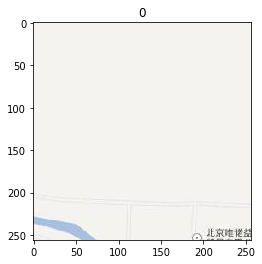

In [101]:
plot_image(image, test_labels[0])

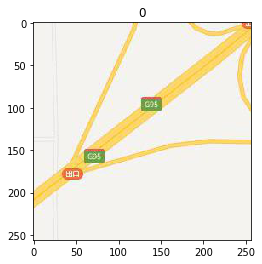

In [102]:
image_2 = mping.imread(test_images[2])
image_2 = tf.image.resize_image_with_crop_or_pad(image_2, IMG_H, IMG_W)
plot_image(image_2, test_labels[2])

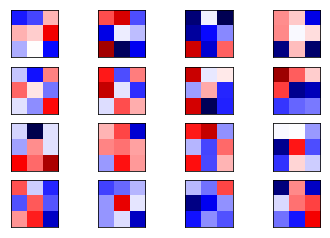

In [103]:
conv1_weights = reader.get_tensor('conv1/weights')
plot_conv_weights(weights=conv1_weights)

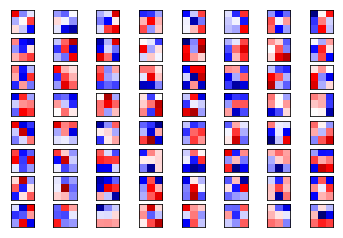

In [104]:
conv3_weights = reader.get_tensor('conv3/weights')
plot_conv_weights(weights=conv3_weights)


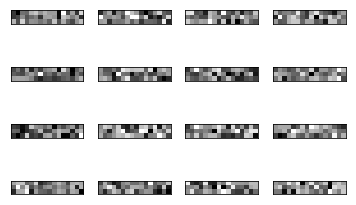

In [109]:
conv3_weights = reader.get_tensor('conv2/weights')
plot_conv_layer(layer=conv3_weights, image=image_2)